<a href="https://colab.research.google.com/github/katarinagresova/AgoBind/blob/cascade/experiments/Cascade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [1]:
!git clone https://github.com/ML-Bioinfo-CEITEC/miRBind.git
%cd miRBind

Cloning into 'miRBind'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 233 (delta 35), reused 39 (delta 12), pack-reused 158
Receiving objects: 100% (233/233), 40.86 MiB | 25.70 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/miRBind


# Model architecture

In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.layers import (
                                BatchNormalization, LeakyReLU,
                                Input, Dense, Conv2D,
                                MaxPooling2D, Flatten, Dropout)
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa


def one_hot_encoding(df, tensor_dim=(50, 20, 1)):
    """
    fun transform input database to numpy array.
    
    parameters:
    df = Pandas df with col names "gene", "label", "miRNA"
    tensor_dim= 2d matrix shape
    
    output:
    2d dot matrix, labels as np array
    """
    df.reset_index(inplace=True, drop=True)

    # alphabet for watson-crick interactions.
    alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1.}

    # labels to one hot encoding
    label = df["label"].to_numpy()

    # create empty main 2d matrix array
    N = df.shape[0]  # number of samples in df
    shape_matrix_2d = (N, *tensor_dim)  # 2d matrix shape
    # initialize dot matrix with zeros
    ohe_matrix_2d = np.zeros(shape_matrix_2d, dtype="float32")

    # compile matrix with watson-crick interactions.
    for index, row in df.iterrows():
        for bind_index, bind_nt in enumerate(row.gene.upper()):

            for mirna_index, mirna_nt in enumerate(row.miRNA.upper()):

                base_pairs = bind_nt + mirna_nt
                ohe_matrix_2d[index, bind_index, mirna_index, 0] = alphabet.get(base_pairs, 0)

    return ohe_matrix_2d, label


def make_architecture():
    """
    build model architecture

    return a model object
    """
    main_input = Input(shape=(50, 20, 1),
                       dtype='float32', name='main_input'
                       )

    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_1")(main_input)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_1')(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_2")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_2')(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_3")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_3')(x)
    x = Dropout(rate=0.25)(x)

    conv_flat = Flatten(name='2d_matrix')(x)

    x = Dense(128)(conv_flat)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)

    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)

    x = Dense(32)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)

    main_output = Dense(1, activation='sigmoid', name='main_output')(x)

    m = K.Model(inputs=[main_input], outputs=[main_output], name='arch_00')

    return m

METRICS = [
      K.metrics.TruePositives(name='tp'),
      K.metrics.FalsePositives(name='fp'),
      K.metrics.TrueNegatives(name='tn'),
      K.metrics.FalseNegatives(name='fn'), 
      K.metrics.BinaryAccuracy(name='accuracy'),
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      K.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def compile_model(metrics=METRICS):
    K.backend.clear_session()
    m = make_architecture()

    opt = Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam")

    m.compile(
        optimizer=opt,
        loss=tfa.losses.SigmoidFocalCrossEntropy(),
        metrics=metrics
        )
    return m


def plot_history(history):
    """
    plot history of the training of the model,
    accuracy and loss of the training and validation set
    """

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6), dpi=80)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Recall')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()


# Train data 1:10 preparation

In [16]:
training_ratio = 10
train_df = pd.read_csv("Datasets/train_set_1_" + str(training_ratio) + "_CLASH2013_paper.tsv", sep='\t')
# set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
train_df = train_df.sample(frac=1, random_state=RANDOM_STATE)
print(train_df.head())
ohe_data = one_hot_encoding(train_df)
train_ohe, train_labels = ohe_data

                       miRNA  \
45236   ACTGCATTATGAGCACTTAA   
168824  TATTGCACTTGTCCCGGCCT   
2591    AAAAGCTGGGTTGAGAGGGC   
76746   TCTCACACAGAAATCGCACC   
63277   TGAGGTAGTAGTTTGTGCTG   

                                                     gene  label  
45236   GAGAAGAAATCTGGCTGGTTTGAGGGTTTCCTTTAGTTCACCCTCA...      0  
168824  GTAAATGTCTGTTTTTCATAATTGCTCTTTATATTGTGTGTTATCT...      0  
2591    GTACCCAGTAAAAACCAGAATGACCCATTGCCAGGACGCATCAAAG...      1  
76746   ACGTCGGCGCCATGCTCCAGGTACAGAGCCACATGTTGCTCCAGGC...      0  
63277   ACCAATGCCAGAGGAGCAACAGCGGCAACCTTTGGCACTGCATCCA...      0  


In [17]:
print("Number of samples: ", train_df.shape[0])
print("Positives: ", np.sum(train_labels == 1))
print("Negatives: ", np.sum(train_labels == 0))

Number of samples:  169312
Positives:  15392
Negatives:  153920


# Creating model

In [14]:
model = compile_model()
model.summary()

Model: "arch_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 50, 20, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 50, 20, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 20, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 50, 20, 32)       128       
 ormalization)                                                   
                                                                 
 Max_1 (MaxPooling2D)        (None, 25, 10, 32)        0         
                                                                 
 dropout (Dropout)           (None, 25, 10, 32)        0         
                                                           

# Model focused on recall

## Train subsampler

Epoch 1/20
5027/5027 [==============================] - 72s 13ms/step - loss: 0.3601 - tp: 13313.0000 - fp: 83587.0000 - tn: 62639.0000 - fn: 1307.0000 - accuracy: 0.4722 - precision: 0.1374 - recall: 0.9106 - auc: 0.7962 - prc: 0.2826 - val_loss: 0.0660 - val_tp: 652.0000 - val_fp: 1013.0000 - val_tn: 6681.0000 - val_fn: 120.0000 - val_accuracy: 0.8662 - val_precision: 0.3916 - val_recall: 0.8446 - val_auc: 0.9285 - val_prc: 0.6766
Epoch 2/20
5027/5027 [==============================] - 67s 13ms/step - loss: 0.2485 - tp: 13710.0000 - fp: 55667.0000 - tn: 90559.0000 - fn: 910.0000 - accuracy: 0.6483 - precision: 0.1976 - recall: 0.9378 - auc: 0.9032 - prc: 0.5586 - val_loss: 0.0779 - val_tp: 704.0000 - val_fp: 1301.0000 - val_tn: 6393.0000 - val_fn: 68.0000 - val_accuracy: 0.8383 - val_precision: 0.3511 - val_recall: 0.9119 - val_auc: 0.9453 - val_prc: 0.7496
Epoch 3/20
5027/5027 [==============================] - 74s 15ms/step - loss: 0.2223 - tp: 13778.0000 - fp: 45205.0000 - tn: 101

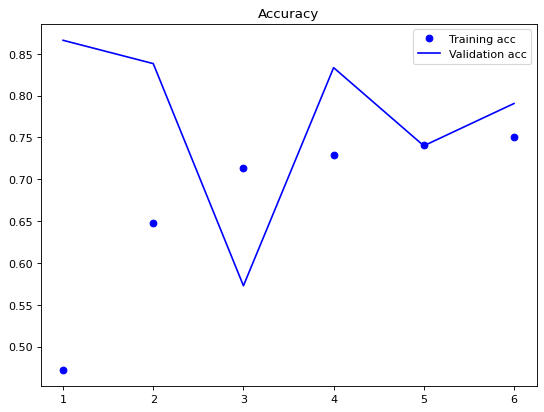

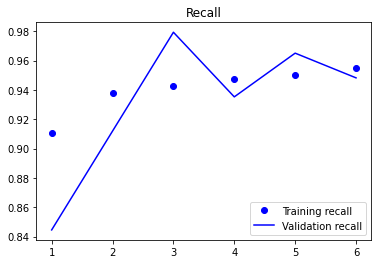

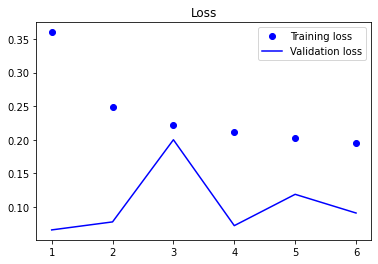

In [18]:
monitor_val_recall = EarlyStopping(monitor = 'val_recall', patience = 5)
model_history = model.fit(
    train_ohe, train_labels,
    validation_split=0.05, epochs=20,
    batch_size=32,
    class_weight={0: 1, 1: 10*training_ratio},
    callbacks=[monitor_val_recall]
    )

plot_history(model_history)

model.save("model_1_" + str(training_ratio) + "focal.h5")

## Subsample training data

In [19]:
predictions = model.predict(train_ohe)

In [20]:
predictions_df = pd.DataFrame(np.array([predictions[:,0], train_labels]).T, columns=['preds', 'labels'])
predictions_df

,preds,labels
0,0.389498,0.0
1,0.716711,0.0
2,0.688159,1.0
3,0.345570,0.0
4,0.262400,0.0
...,...,...
169307,0.442226,0.0
169308,0.510231,0.0
169309,0.423305,0.0
169310,0.340313,0.0


In [27]:
threshold = 0.4

predictions_sub = predictions_df[predictions_df['preds'] > threshold]['preds']
train_ohe_sub = train_ohe[predictions_df[predictions_df['preds'] > threshold].index]
train_labels_sub = train_labels[predictions_df[predictions_df['preds'] > threshold].index]

In [28]:
print("Number of samples: ", len(train_labels_sub))
print("Positives: ", np.sum(train_labels_sub == 1))
print("Negatives: ", np.sum(train_labels_sub == 0))

Number of samples:  74978
Positives:  15241
Negatives:  59737


## Tran classificator on subsampled data

In [29]:
model2 = compile_model()
model2.summary()

Model: "arch_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 50, 20, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 50, 20, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 20, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 50, 20, 32)       128       
 ormalization)                                                   
                                                                 
 Max_1 (MaxPooling2D)        (None, 25, 10, 32)        0         
                                                                 
 dropout (Dropout)           (None, 25, 10, 32)        0         
                                                           

Epoch 1/10
2226/2226 [==============================] - 28s 12ms/step - loss: 0.1159 - tp: 11640.0000 - fp: 8199.0000 - tn: 48545.0000 - fn: 2845.0000 - accuracy: 0.8450 - precision: 0.5867 - recall: 0.8036 - auc: 0.8982 - prc: 0.7405 - val_loss: 0.0481 - val_tp: 613.0000 - val_fp: 274.0000 - val_tn: 2719.0000 - val_fn: 143.0000 - val_accuracy: 0.8888 - val_precision: 0.6911 - val_recall: 0.8108 - val_auc: 0.9311 - val_prc: 0.8289
Epoch 2/10
2226/2226 [==============================] - 28s 12ms/step - loss: 0.1132 - tp: 11743.0000 - fp: 7903.0000 - tn: 48841.0000 - fn: 2742.0000 - accuracy: 0.8506 - precision: 0.5977 - recall: 0.8107 - auc: 0.9036 - prc: 0.7482 - val_loss: 0.0437 - val_tp: 605.0000 - val_fp: 245.0000 - val_tn: 2748.0000 - val_fn: 151.0000 - val_accuracy: 0.8944 - val_precision: 0.7118 - val_recall: 0.8003 - val_auc: 0.9318 - val_prc: 0.8301
Epoch 3/10
2226/2226 [==============================] - 28s 12ms/step - loss: 0.1117 - tp: 11747.0000 - fp: 7820.0000 - tn: 48924.

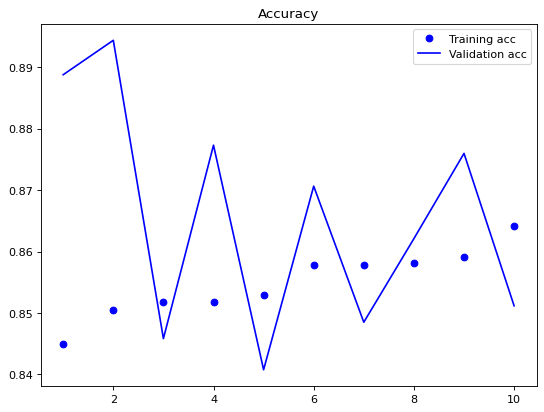

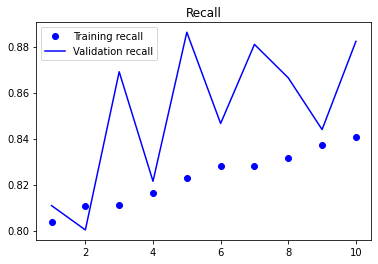

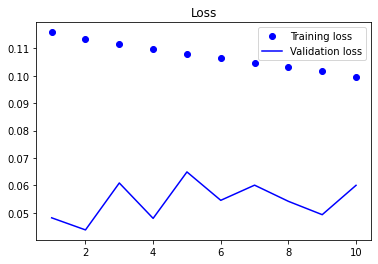

In [57]:
#monitor_val_recall = EarlyStopping(monitor = 'val_recall', patience = 5)
model_history = model2.fit(
    train_ohe_sub, train_labels_sub,
    validation_split=0.05, epochs=10,
    batch_size=32,
    class_weight={0: 1, 1: training_ratio},
#    callbacks=[monitor_val_recall]
    )

plot_history(model_history)

model.save("model2_1_" + str(training_ratio) + "focal.h5")

## Evaluate

In [31]:
dataset_ratio = '10'
df = pd.read_csv("Datasets/test_set_1_" + dataset_ratio + "_CLASH2013_paper.tsv", sep='\t')
ohe_data = one_hot_encoding(df)
test_ohe, test_labels = ohe_data

In [32]:
print("Number of samples: ", df.shape[0])
print("Positives: ", np.sum(test_labels == 1))
print("Negatives: ", np.sum(test_labels == 0))

Number of samples:  22000
Positives:  2000
Negatives:  20000


In [33]:
model_10_focal_predictions = model.predict(test_ohe)

Model 1:10 Focal auc 0.7614674039217768


Text(0, 0.5, 'Precision')

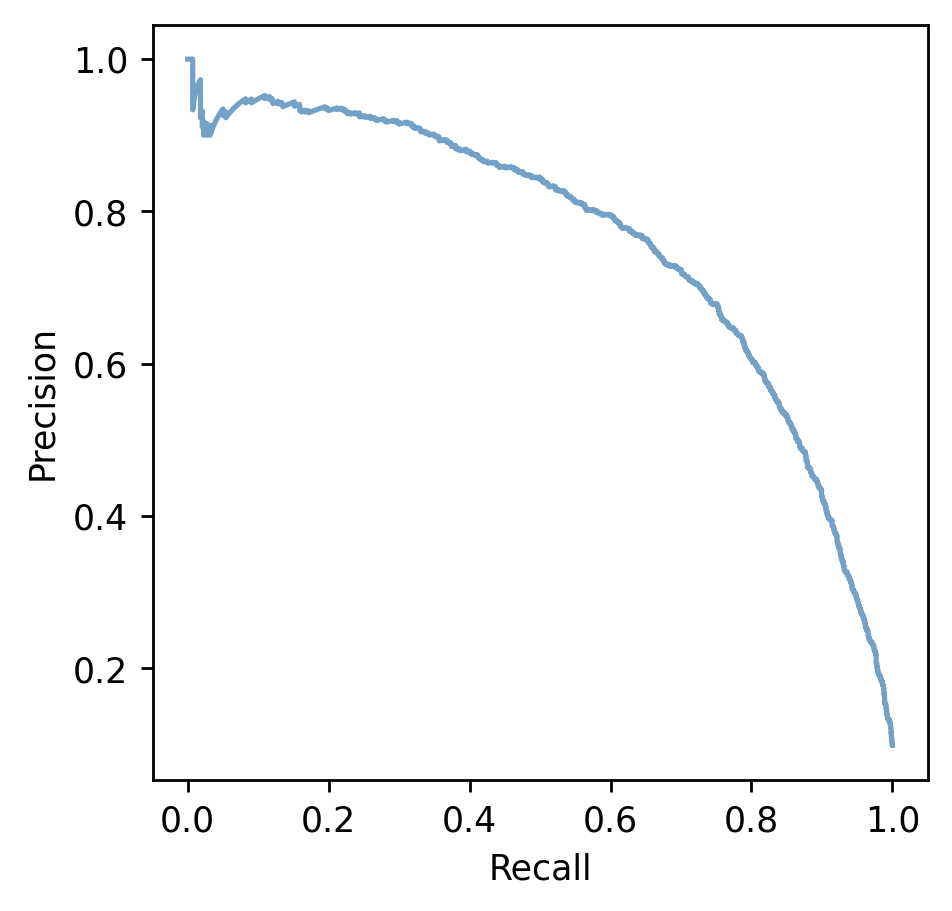

In [34]:
from sklearn import metrics

plt.figure(figsize=(4, 4), dpi=250)

precision, recall, threshold = precision_recall_curve(test_labels, model_10_focal_predictions)
print("Model 1:10 Focal auc", metrics.auc(recall, precision))
plt.plot(recall, precision, label='miRBind10_focal', marker=',', color='#73a2c6')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [35]:
from sklearn.metrics import precision_score, recall_score

def print_precision_recall(labels, model_10_recall_predictions, threshold = 0.5):
  recall = recall_score(labels, model_10_recall_predictions > threshold)
  precision = precision_score(labels, model_10_recall_predictions > threshold)

  print(precision)
  print(recall)

In [36]:
print_precision_recall(test_labels, model_10_focal_predictions, threshold = 0.5)

0.29946185501741057
0.946


In [37]:
print_precision_recall(test_labels, model_10_focal_predictions, threshold = 0.4)

0.20135816442020785
0.9785


In [38]:
print_precision_recall(test_labels, model_10_focal_predictions, threshold = 0.3)

0.13409780775716695
0.994


In [39]:
print_precision_recall(test_labels, model_10_focal_predictions, threshold = 0.2)

0.09942800298433226
0.9995


In [40]:
print_precision_recall(test_labels, model_10_focal_predictions, threshold = 0.1)

0.09128251939753537
1.0


In [41]:
print_precision_recall(test_labels, model_10_focal_predictions, threshold = 0.05)

0.09091322332833311
1.0


## Subsample data

In [42]:
model_10_predictions_df = pd.DataFrame(np.array([model_10_focal_predictions[:,0], test_labels]).T, columns=['preds', 'labels'])
model_10_predictions_df

,preds,labels
0,0.934167,1.0
1,0.947624,1.0
2,0.712323,1.0
3,0.878211,1.0
4,0.742441,1.0
...,...,...
21995,0.167755,0.0
21996,0.627525,0.0
21997,0.354000,0.0
21998,0.541440,0.0


In [53]:
threshold = 0.5

model_10_predictions_sub = model_10_predictions_df[model_10_predictions_df['preds'] > threshold]['preds']
test_ohe_sub = test_ohe[model_10_predictions_df[model_10_predictions_df['preds'] > threshold].index]
test_labels_sub = test_labels[model_10_predictions_df[model_10_predictions_df['preds'] > threshold].index]

In [54]:
print("Number of samples: ", len(test_labels_sub))
print("Positives: ", np.sum(test_labels_sub == 1))
print("Negatives: ", np.sum(test_labels_sub == 0))

Number of samples:  6318
Positives:  1892
Negatives:  4426


## 1:10 model

In [58]:
model_10_predictions = model2.predict(test_ohe_sub)

Model 1:1 auc 0.8217599492561048


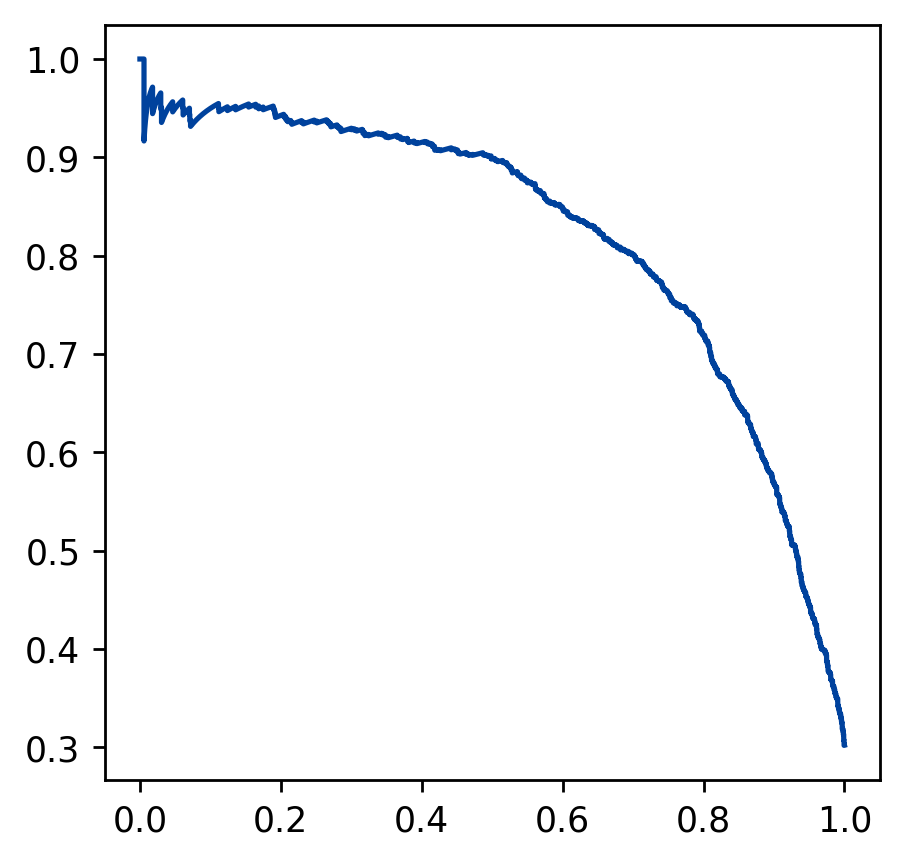

In [59]:
plt.figure(figsize=(4, 4), dpi=250)

precision, recall, _ = precision_recall_curve(test_labels_sub, model_10_predictions)
print("Model 1:1 auc", metrics.auc(recall, precision))
plt.plot(recall, precision, label='miRBind1', marker=',', color='#00429d')

# 1:1 model

In [ ]:
model_1 = K.models.load_model("Models/model_1_1.h5")
model_1_predictions = model_1.predict(seq_ohe_sub)

Model 1:1 auc 0.7721416204447423


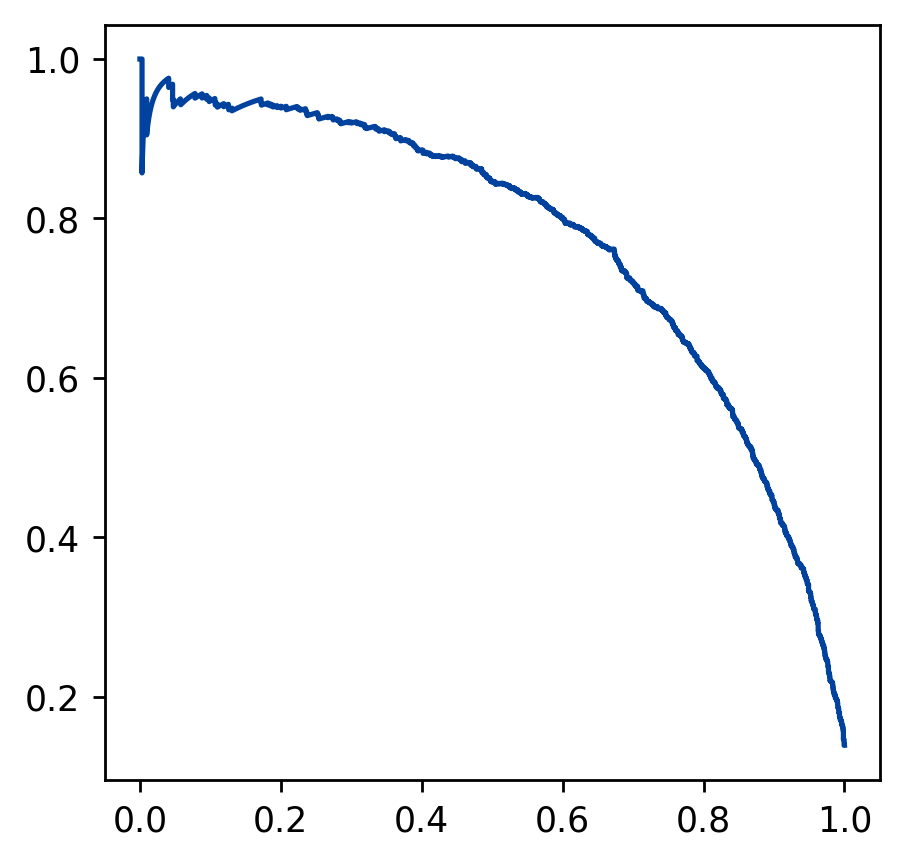

In [ ]:
plt.figure(figsize=(4, 4), dpi=250)

precision, recall, _ = precision_recall_curve(labels_sub, model_1_predictions)
print("Model 1:1 auc", metrics.auc(recall, precision))
plt.plot(recall, precision, label='miRBind1', marker=',', color='#00429d')

In [ ]:
model_10 = K.models.load_model("Models/model_1_10.h5")
model_10_predictions = model_10.predict(seq_ohe_sub)

Model 1:10 auc 0.7842652428636406


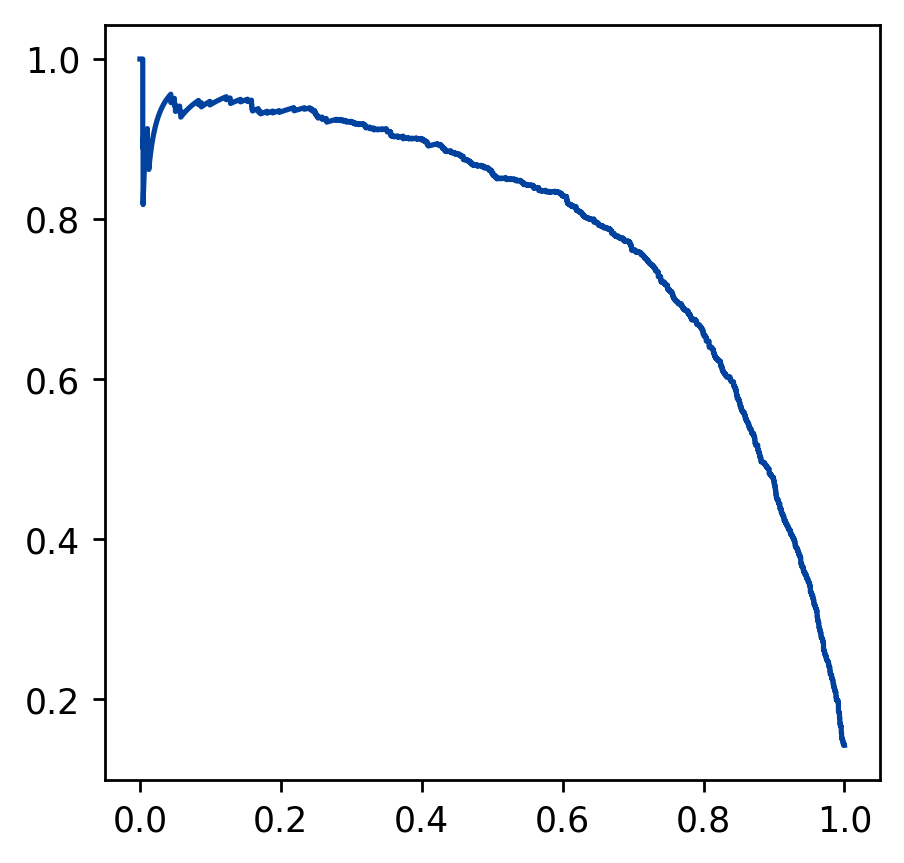

In [ ]:
plt.figure(figsize=(4, 4), dpi=250)

precision, recall, _ = precision_recall_curve(labels_sub, model_10_predictions)
print("Model 1:10 auc", metrics.auc(recall, precision))
plt.plot(recall, precision, label='miRBind10', marker=',', color='#00429d')